In [429]:
import warnings
import os
import time
import itertools

# Our numerical workhorse
import numpy as np
import scipy
import pandas as pd
import bebi103

# Image processing tools
import skimage
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.feature
import skimage.segmentation
import skimage.measure

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.filterwarnings('ignore')

# Part A

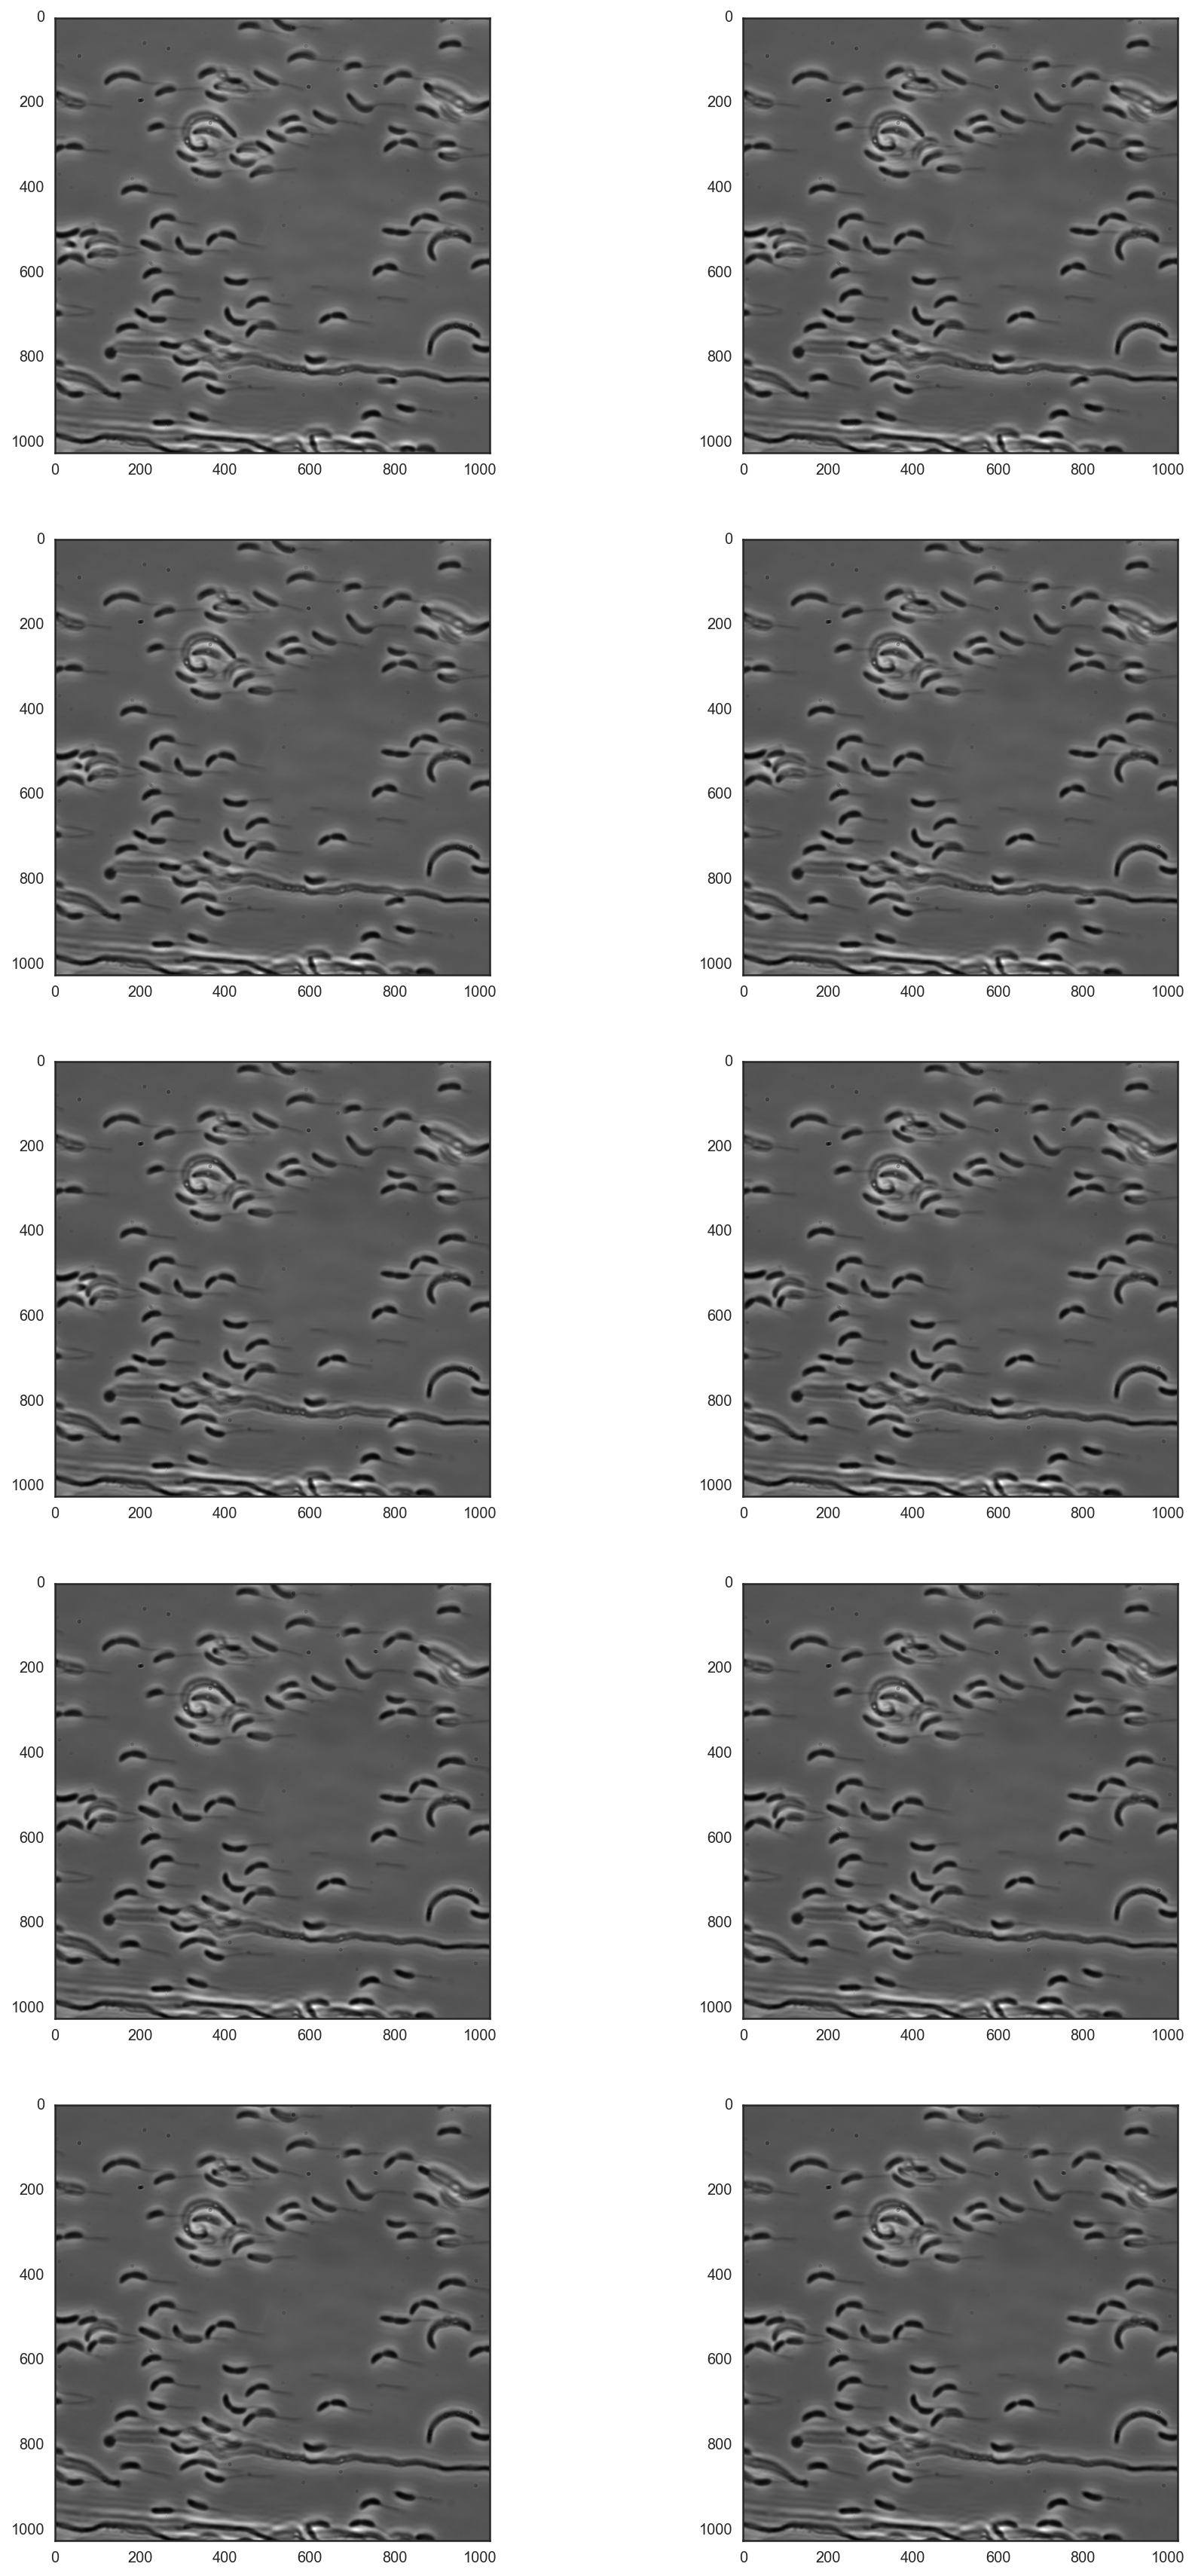

In [51]:
image_dir = '/Users/elenaperry/Dropbox/Caltech/bebi103/hw8_iyer-biswas_et_al\
/sequential_full_field/phase0300'

im_list = []
im_float_list = []
f = plt.figure(figsize=(15,30))

for i in range(10):
    im_list.append(image_dir + str(i) + '.tif')

    im = skimage.io.imread(im_list[i])
    im_float_list.append((im.astype(float) - im.min()) / (im.max() - im.min()))
    
for i in range(10):
    with sns.axes_style('white'):
        plt.subplot(5,2,i+1)
        plt.imshow(im_float_list[i], cmap=plt.cm.gray)

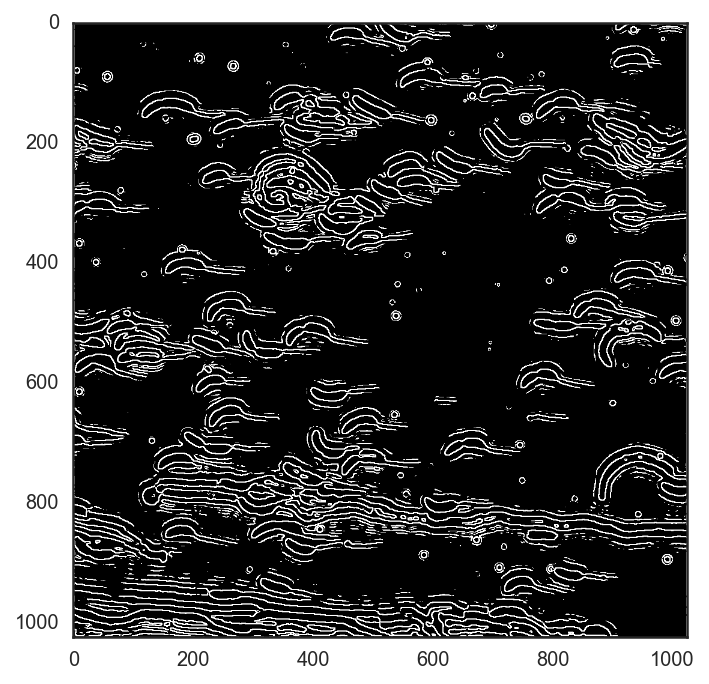

In [52]:
# Compute LoG
im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float_list[0], 2.0)

def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filters.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)

# Find zero-crossings
im_edge = zero_crossing_filter(im_LoG, 0.001)

# Show result
with sns.axes_style('white'):
    plt.imshow(im_edge, cmap=plt.cm.gray)

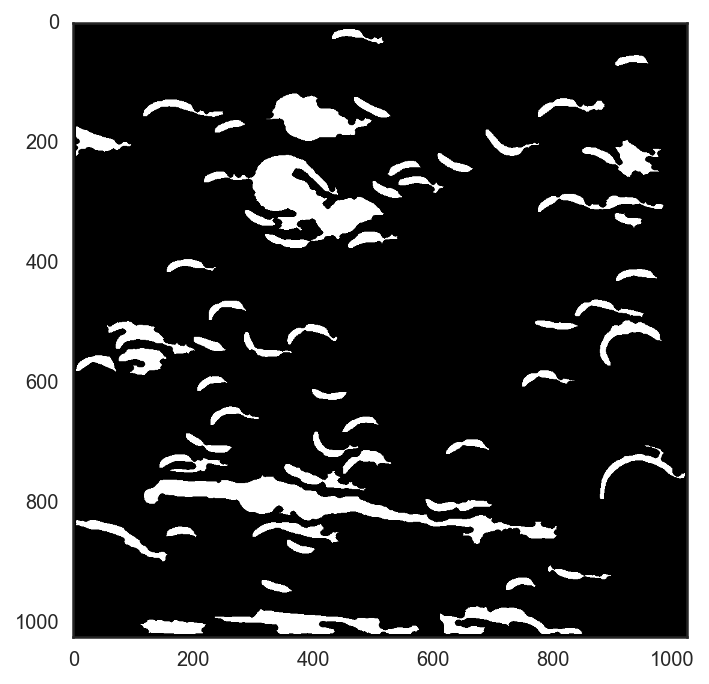

In [53]:
# Structuring element is radius 2 disk
selem = skimage.morphology.disk(2)

# Close binary image
im_bw_close = skimage.morphology.binary_closing(im_edge, selem)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw_close, min_size=500)

# Fill holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_bw)

# Structuring element is radius 3 disk
selem = skimage.morphology.disk(3)

# Erode binary image again
im_bw_eroded = skimage.morphology.erosion(im_bw, selem)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw_eroded, min_size=500)

# Show result
with sns.axes_style('white'):
    plt.imshow(im_bw, cmap=plt.cm.gray)

# Part B

In [3]:
image_dir = '/Users/elenaperry/Dropbox/Caltech/bebi103/hw8_iyer-biswas_et_al/'
im_bac_1_file = os.path.join(image_dir, 'bacterium_1.tif')
im_bac_2_file = os.path.join(image_dir, 'bacterium_2.tif')

im_bac_1 = skimage.io.imread(im_bac_1_file)
im_bac_2 = skimage.io.imread(im_bac_2_file)

im_bac_1_float = np.empty(im_bac_1.shape)
for i in range(len(im_bac_1)):
    im_bac_1_float[i] = (im_bac_1[i].astype(float) - im_bac_1[i].min()) / (im_bac_1[i].max() - im_bac_1[i].min())

im_bac_2_float = np.empty(im_bac_2.shape)
for i in range(len(im_bac_2)):
    im_bac_2_float[i] = (im_bac_2[i].astype(float) - im_bac_2[i].min()) / (im_bac_2[i].max() - im_bac_2[i].min())

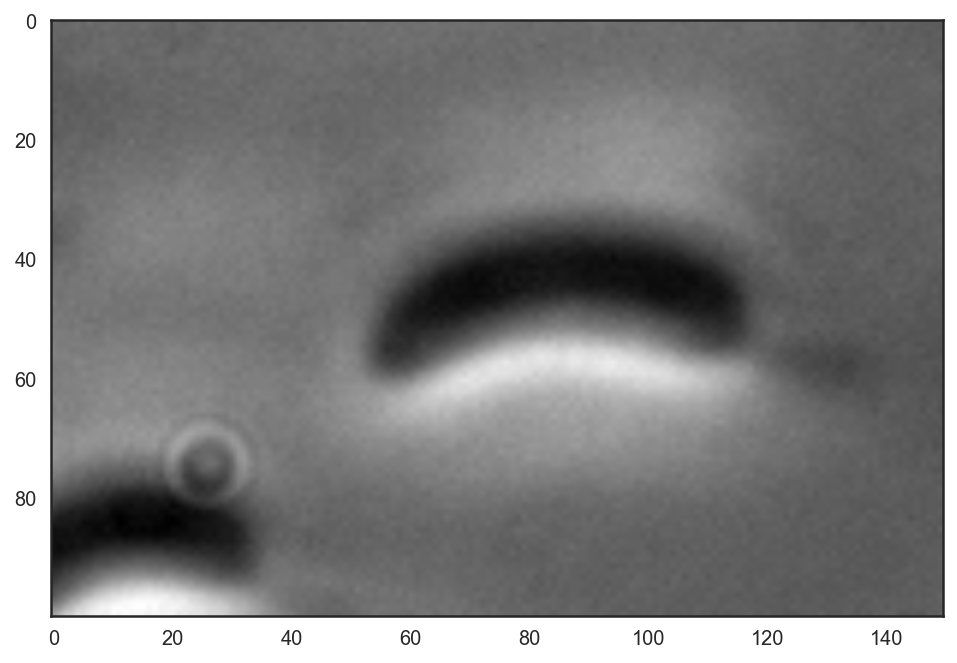

In [50]:
with sns.axes_style('white'):
    #fig, ax = plt.subplots(1, 2)
    #ax[0].imshow(im_bac_1_float[0], cmap=plt.cm.gray)
    #ax[1].imshow(im_bac_2_float[0], cmap=plt.cm.gray)
    plt.imshow(im_bac_1_float[554], cmap=plt.cm.gray)

In [ ]:
_ = plt.hist(im_bac_1_float[0], bins=20, histtype='step')

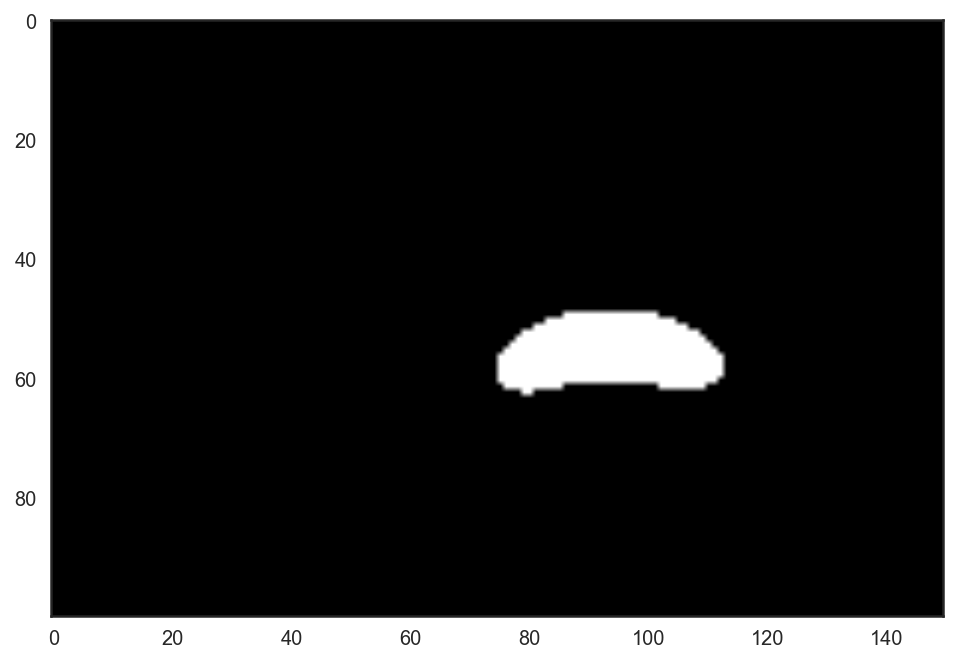

In [96]:
threshold = 0.3
im_bac_1_thresh = im_bac_1_float < threshold
for i in range(len(im_bac_1_thresh)):
    skimage.segmentation.clear_border(im_bac_1_thresh[i])

im_bac_1_thresh = im_bac_1_thresh.astype(int)
with sns.axes_style('white'):
    plt.imshow(im_bac_1_thresh[1], cmap=plt.cm.gray)

In [100]:
max_area1 = np.array([0.01] * len(im_bac_1_thresh))

for i in range(len(im_bac_1_thresh)):
    selem = skimage.morphology.square(2)
    im_bw_eroded = skimage.morphology.erosion(im_bac_1_thresh[i], selem)
    # Label binary image
    im_labeled, n_labels = skimage.measure.label(
                                im_bw_eroded, background=-1, return_num=True)

    # Get area of each bacterium and store the largest area in case of more than one bacterium
    physical_size = 0.052
    im_props = skimage.measure.regionprops(im_labeled)
    for prop in im_props:
        #print("""
        #bacterium {0:d}: area = {1:.1f} µm^2
        #""".format(prop.label, prop.area * physical_size**2))
        if prop.area * physical_size**2 > max_area1[i]:
            max_area1[i] = prop.area * physical_size**2

(array([1066, 1262, 1361, 1632]),)


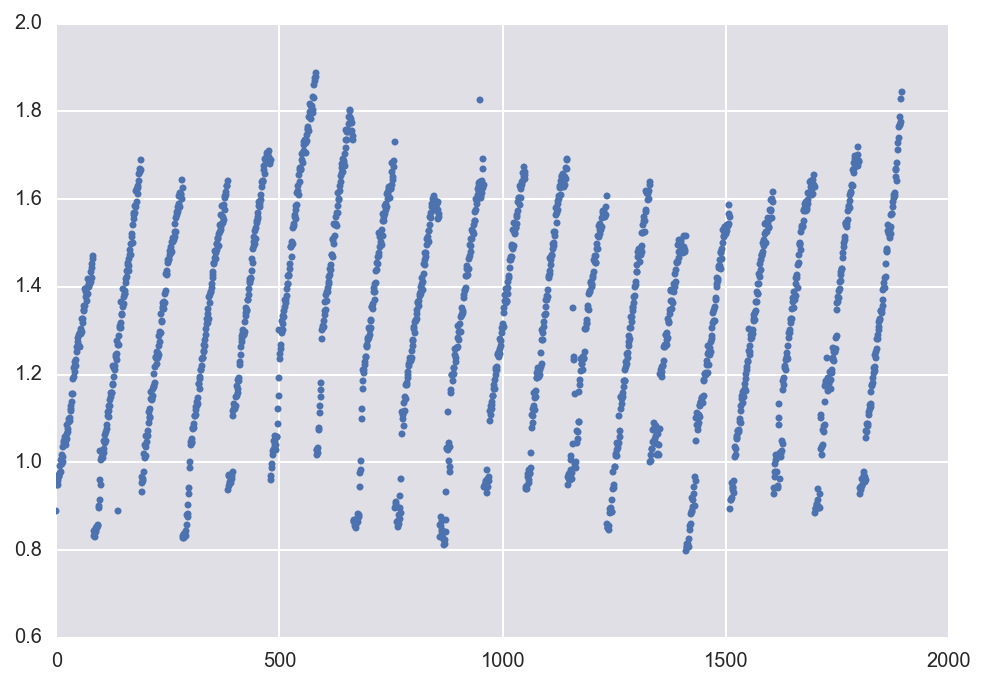

In [101]:
print(np.where(max_area1 < 0.7))
areas = max_area1[(max_area1 > 0.7) & (max_area1 < 2.0)]
area_diff = np.diff(areas)
plt.plot(np.arange(len(areas)), areas, '.')

In [189]:
inter_div_inds = np.where(area_diff < -0.5)[0]
inter_div_time = np.diff(inter_div_inds)

# problem: because some frames were dropped, some of the inter_div_times will be a couple of minutes off (this can be fixed)

In [4]:
def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filters.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)


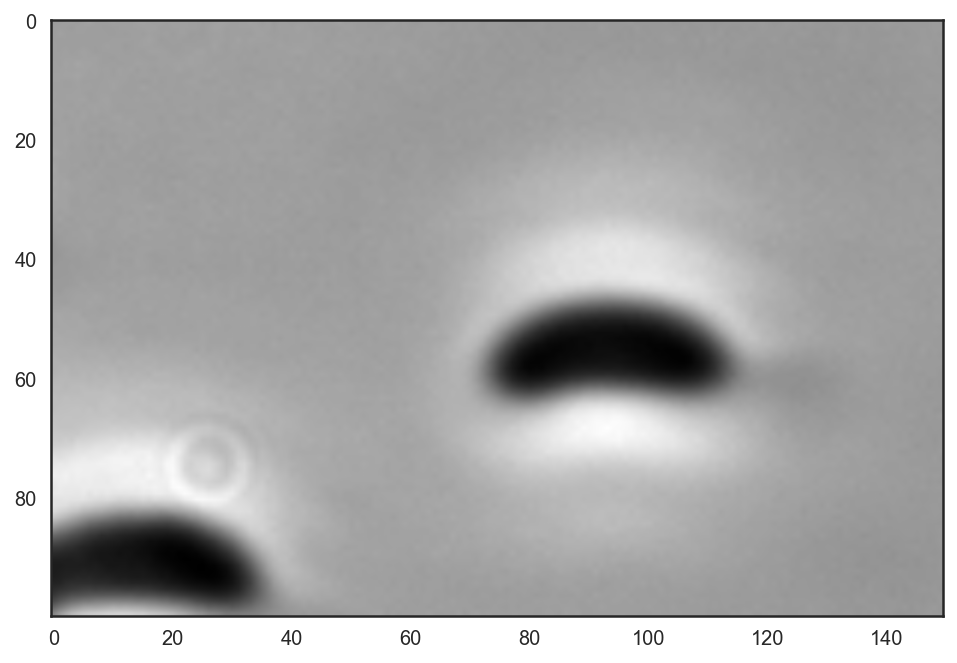

In [330]:
with sns.axes_style('white'):
    #fig, ax = plt.subplots(1, 2)
    #ax[0].imshow(im_bac_1_float[0], cmap=plt.cm.gray)
    #ax[1].imshow(im_bac_2_float[0], cmap=plt.cm.gray)
    plt.imshow(im_bac_1_float[1], cmap=plt.cm.gray)

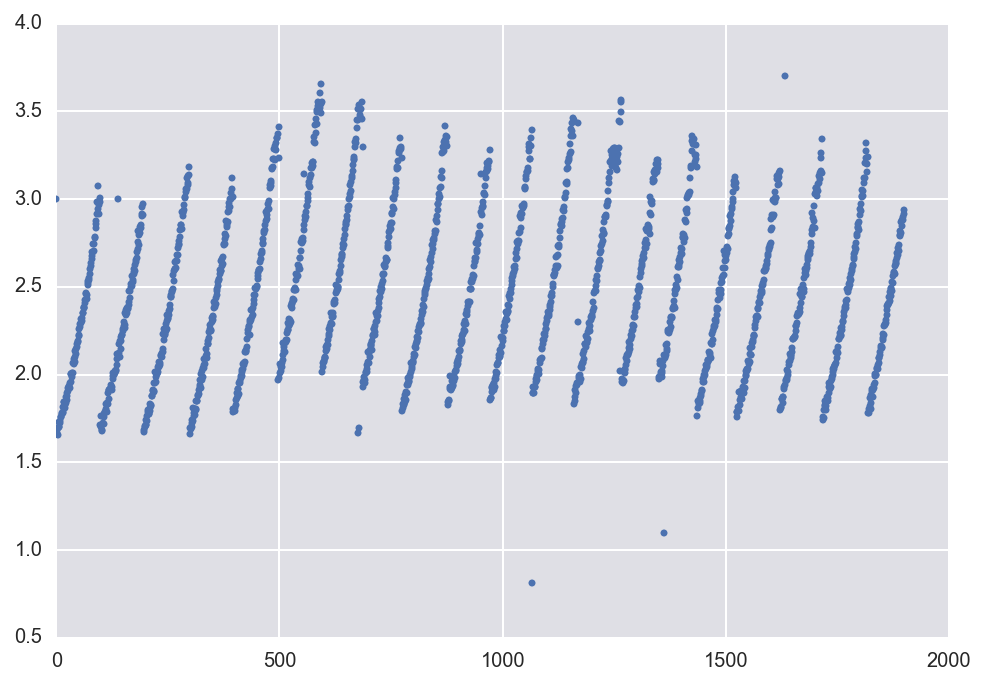

In [94]:
max_area = np.array([0.01] * len(im_bac_1_float))

for i in range(len(im_bac_1_float)):
    # Compute LoG
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_bac_1_float[i], 3.0)

    # Find zero-crossings
    im_edge = zero_crossing_filter(im_LoG, 0.002)

    # Structuring element is radius 2 disk
    selem = skimage.morphology.disk(4)

    # Close binary image
    im_bw_close = skimage.morphology.binary_closing(im_edge, selem)

    im_skel = skimage.morphology.skeletonize(im_bw_close)

    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_skel)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=50)
    
    # Label binary image
    im_labeled, n_labels = skimage.measure.label(im_bw, background=-1, return_num=True)

    # Get area of each bacterium and store the largest area in case of more than one bacterium
    physical_size = 0.052
    im_props = skimage.measure.regionprops(im_labeled)
    for prop in im_props:
        #print("""
        #bacterium {0:d}: area = {1:.1f} µm^2
        #""".format(prop.label, prop.area * physical_size**2))
        if prop.area * physical_size**2 > max_area[i]:
            max_area[i] = prop.area * physical_size**2

plt.plot(np.arange(len(im_bac_1_float)), max_area, '.')

In [321]:
np.where(max_area < 1.5)

(array([1066, 1361]),)

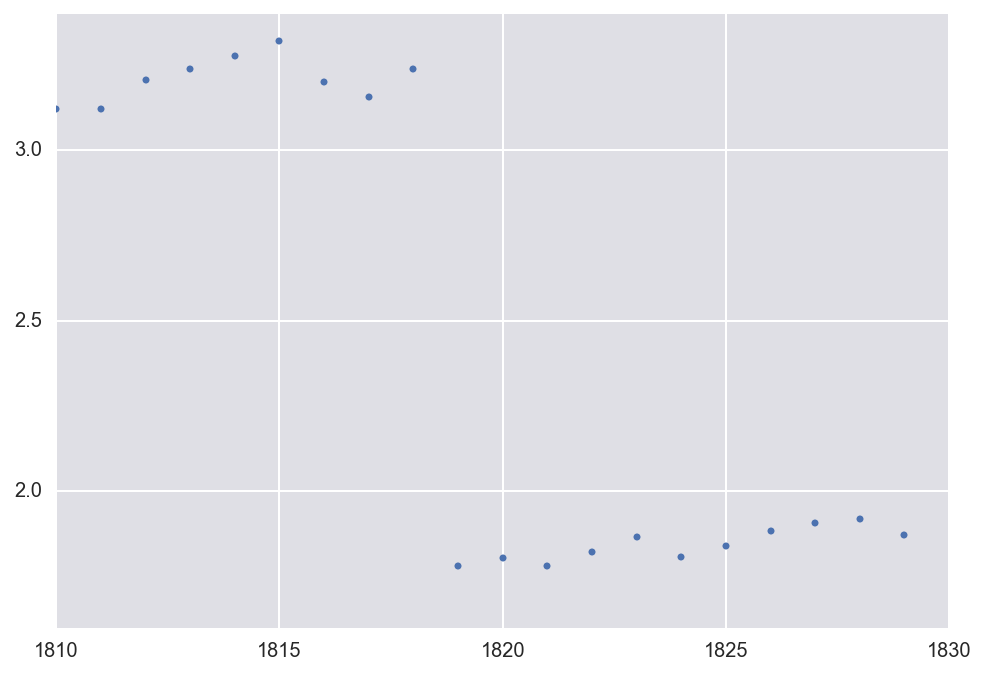

In [355]:
plt.plot(np.arange(1810, 1830), max_area[1810:1830], '.')

In [356]:
np.diff(max_area[1818:1820])

array([-1.46016])

In [319]:
new_max_area = np.copy(max_area)
for i in np.where(max_area < 1.5)[0]:
    new_max_area[i] = new_max_area[i+1]
    

In [363]:
new_areas = new_max_area[(new_max_area > 1.5)]
new_area_diff = np.diff(new_areas)
new_inter_div_inds = np.where(new_area_diff < -1.0)[0]
new_inter_div_inds_list = []
for i in np.arange(1, len(new_inter_div_inds)):
    if new_inter_div_inds[i] - new_inter_div_inds[i-1] > 50:
        new_inter_div_inds_list.append(new_inter_div_inds[i-1])
if new_inter_div_inds[-1] - new_inter_div_inds[-2] > 50:
    new_inter_div_inds_list.append(new_inter_div_inds[-1])
new_inter_div_inds = np.array(new_inter_div_inds_list)        
new_inter_div_time = np.diff(new_inter_div_inds)
new_inter_div_inds

array([   0,   98,  195,  298,  395,  499,  595,  686,  774,  876,  971,
       1065, 1169, 1266, 1349, 1435, 1523, 1632, 1716, 1818])

In [359]:
areas = max_area[(max_area > 1.5)]
area_diff = np.diff(areas)
inter_div_inds = np.where(area_diff < -1.1)[0]
inter_div_inds_list = []
# for i in range(len(inter_div_inds)-1):
#     if inter_div_inds[i+1] - inter_div_inds[i] > 50:
#         inter_div_inds_list.append(inter_div_inds[i])
inter_div_inds = np.array(inter_div_inds)        
inter_div_time = np.diff(inter_div_inds)
inter_div_inds

array([   0,   98,  195,  298,  395,  496,  499,  595,  676,  686,  774,
        876,  971, 1065, 1158, 1168, 1260, 1265, 1348, 1433, 1521, 1619,
       1630, 1714, 1816])


    bacterium 1: area = 2.0 µm^2
    


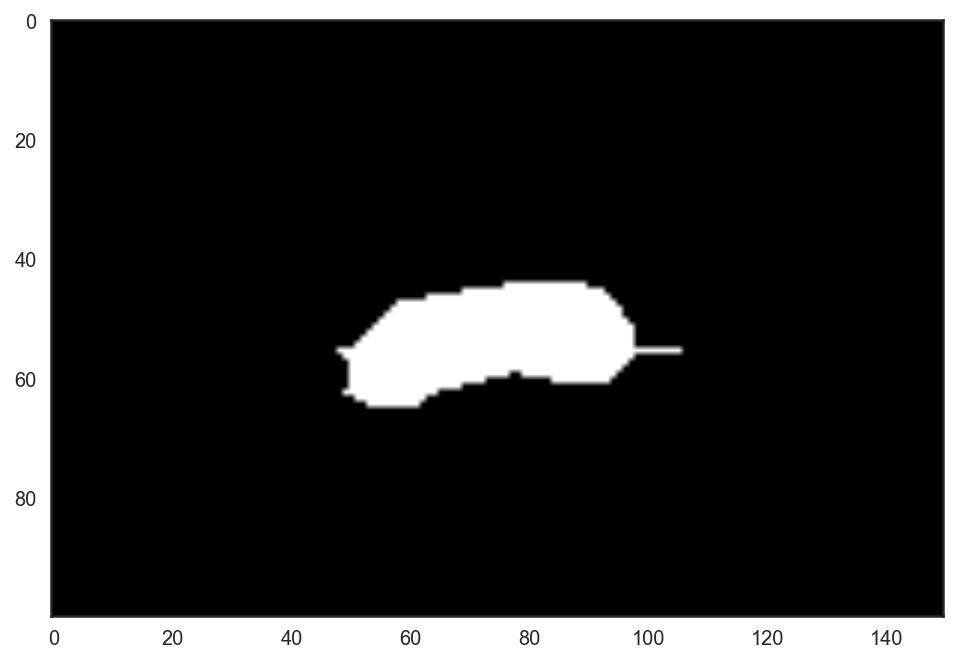

In [294]:

# Compute LoG
im_LoG = scipy.ndimage.filters.gaussian_laplace(im_bac_1_float[1262], 3.0)

# Find zero-crossings
im_edge = zero_crossing_filter(im_LoG, 0.002)

# Structuring element is radius 2 disk
selem = skimage.morphology.disk(4)

# Close binary image
im_bw_dilate = skimage.morphology.dilation(im_edge, selem)

selem = skimage.morphology.disk(2)
im_bw_erode = skimage.morphology.erosion(im_bw_dilate, selem)

im_skel = skimage.morphology.skeletonize(im_bw_erode)

# Fill holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_skel)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=50)

# Label binary image
im_labeled, n_labels = skimage.measure.label(im_bw, background=-1, return_num=True)

# Get area of each bacterium and store the largest area in case of more than one bacterium
physical_size = 0.052
im_props = skimage.measure.regionprops(im_labeled)
for prop in im_props:
    print("""
    bacterium {0:d}: area = {1:.1f} µm^2
    """.format(prop.label, prop.area * physical_size**2))
    #if prop.area * physical_size**2 > max_area[i]:
        #max_area[i] = prop.area * physical_size**2

with sns.axes_style('white'):
    plt.imshow(im_bw, cmap=plt.cm.gray)

time: 153.98606300354004


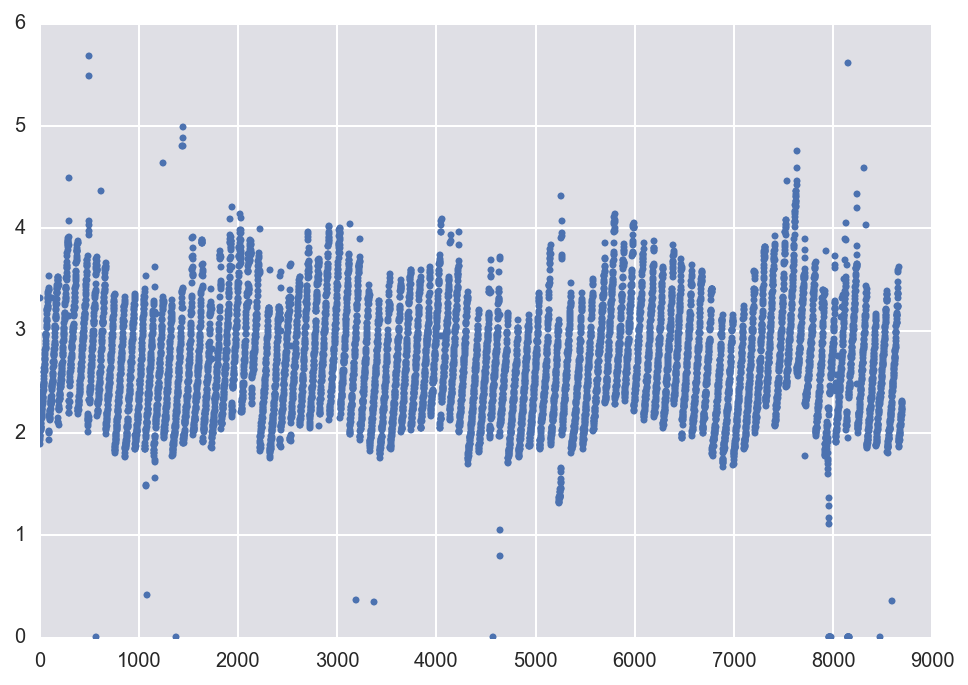

In [196]:
start = time.time()
max_area2 = np.array([0.01] * len(im_bac_2_float))

for i in range(len(im_bac_2_float)):
    # Compute LoG
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_bac_2_float[i], 5.0)

    # Find zero-crossings
    im_edge = zero_crossing_filter(im_LoG, 0.0008)

    # Structuring element is radius 2 disk
    selem = skimage.morphology.disk(5)

    # Close binary image
    im_bw_close = skimage.morphology.binary_closing(im_edge, selem)

    im_skel = skimage.morphology.skeletonize(im_bw_close)

    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_skel)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=50)
    
    # Label binary image
    im_labeled, n_labels = skimage.measure.label(im_bw, background=-1, return_num=True)

    # Get area of each bacterium and store the largest area in case of more than one bacterium
    physical_size = 0.052
    im_props = skimage.measure.regionprops(im_labeled)
    for prop in im_props:
        #print("""
        #bacterium {0:d}: area = {1:.1f} µm^2
        #""".format(prop.label, prop.area * physical_size**2))
        if prop.area * physical_size**2 > max_area2[i] and prop.area * physical_size**2 < 6.0:
            max_area2[i] = prop.area * physical_size**2
print('time: ' + str(time.time() - start))
plt.plot(np.arange(len(im_bac_2_float)), max_area2, '.')

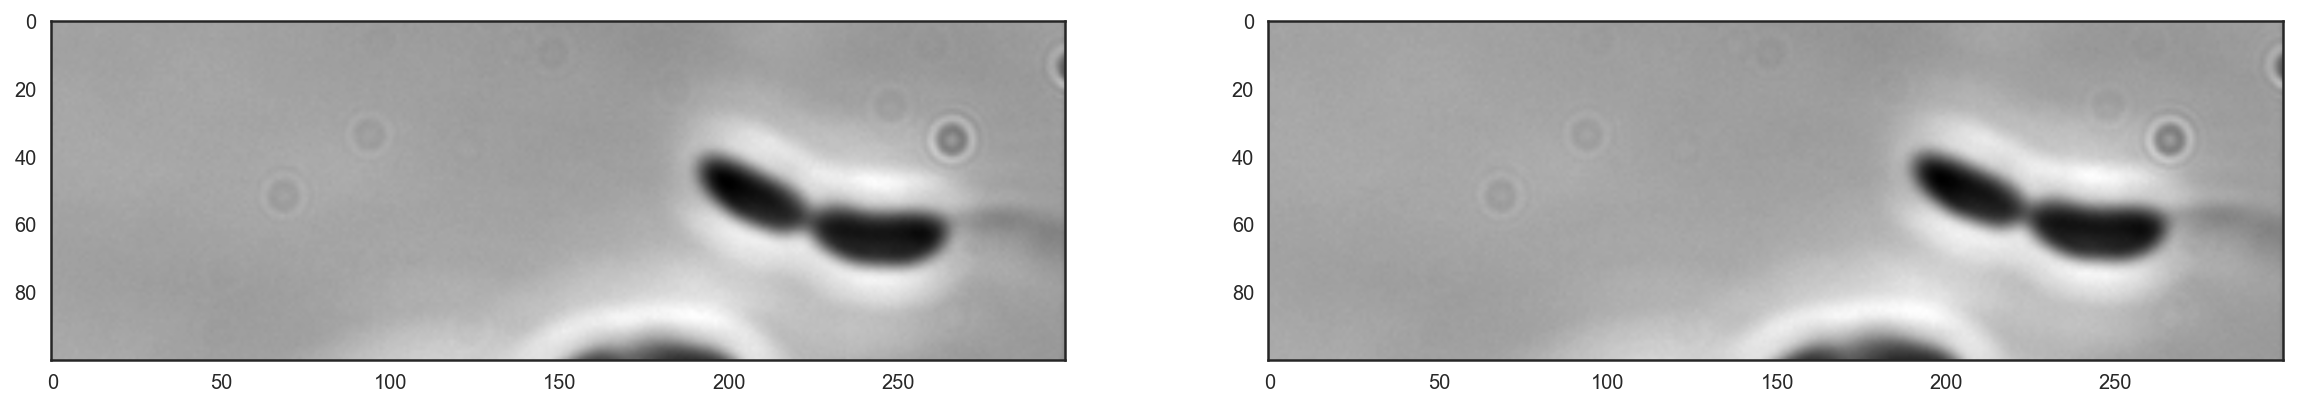

In [251]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    
    ax[0].imshow(im_bac_2_float[1243], cmap=plt.cm.gray)
    ax[1].imshow(im_bac_2_float[1244], cmap=plt.cm.gray)
    #plt.imshow(im_bac_2_float[1446], cmap=plt.cm.gray)

In [252]:
print(im_bac_2_float[1243].sum())
print(im_bac_2_float[1244].sum())

19571.3820481
19694.1473531


In [254]:
len(np.where(max_area2 > 4.5)[0])

11

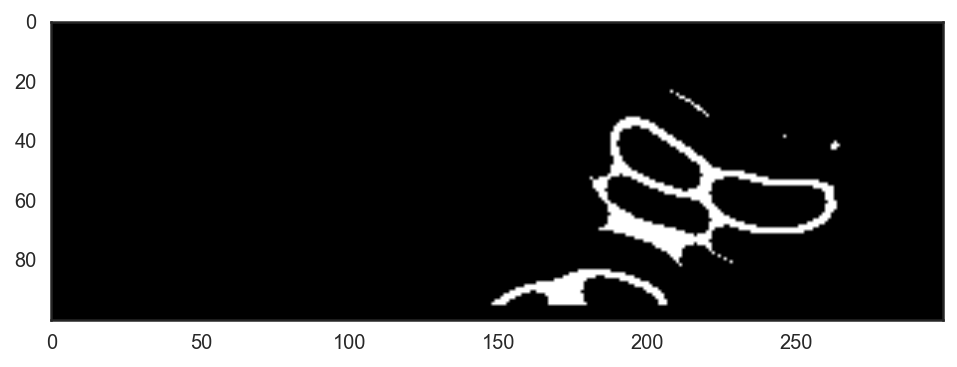

In [238]:
# Compute LoG
im_LoG = scipy.ndimage.filters.gaussian_laplace(im_bac_2_float[1441], 5.0)

# Find zero-crossings
im_edge = zero_crossing_filter(im_LoG, 0.0008)

# Structuring element is radius 2 disk
selem = skimage.morphology.disk(5)

im_edge = skimage.segmentation.clear_border(im_edge)

# Close binary image
im_bw_close = skimage.morphology.binary_closing(im_edge, selem)

#im_skel = skimage.morphology.skeletonize(im_bw_close)

selem = skimage.morphology.disk(2)

im_bw_erode = skimage.morphology.erosion(im_bw_close, selem)

# Close binary image
im_bw_close2 = skimage.morphology.binary_closing(im_bw_erode, selem)

# Fill holes
#im_bw = scipy.ndimage.morphology.binary_fill_holes(im_skel)

# Remove small objectes that are not bacteria
#im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=50)

# Label binary image
#im_labeled, n_labels = skimage.measure.label(im_bw, background=-1, return_num=True)

# Get area of each bacterium and store the largest area in case of more than one bacterium
#physical_size = 0.052
#im_props = skimage.measure.regionprops(im_labeled)
#for prop in im_props:
#    print("""
#    bacterium {0:d}: area = {1:.1f} µm^2
#    """.format(prop.label, prop.area * physical_size**2))
    #if prop.area * physical_size**2 > max_area[i]:
        #max_area[i] = prop.area * physical_size**2

with sns.axes_style('white'):
    plt.imshow(im_bw_close, cmap=plt.cm.gray)

In [255]:
40/len(im_bac_2_float)

0.004597701149425287

# Part C

In [385]:
inds = new_inter_div_inds + 1
inds
init_areas = np.empty(len(inds))
for i, ind in enumerate(inds):
    init_areas[i] = max_area[ind]
inds = np.concatenate((inds, np.array([1899])))
min_area = init_areas.min()
area_series = []
for i in range(len(inds)-1):
    area_series.append(max_area[inds[i]:inds[i+1]][max_area[inds[i]:inds[i+1]] > 1.5])

In [425]:
def exp_theor(params, times):
    a_0, k  = params
    return a_0 * np.exp(k * times)

def lin_theor(params, times):
    a_0, b = params
    return a_0 + b * times

def log_like(params, times, areas, model):
    
    if model == 'lin_theor':  
        a_0, b = params
        areas_theor = lin_theor(params, times)
    elif model == 'exp_theor':
        a_0, k = params
        areas_theor = exp_theor(params, times)
    return -len(times) / 2 * np.log(np.sum((areas - areas_theor)**2))

def log_prior(params, model, a_max=4, a_min=1e-6, k_max=0.01, k_min=1e-6, b_max=0.1, b_min=1e-6):
    if model == 'exp_theor':
        a_0, k = params
        if a_0 < a_min or a_0 > a_max or k < k_min or k > k_max:
            return -np.inf

        prior = np.empty(2)
        prior[0] = a_0 * np.log(a_max / a_min)
        prior[1] = k * np.log(k_max / k_min)
    
        return -np.log(prior).sum()
       
    elif model == 'lin_theor':
        a_0, b = params
        if a_0 < a_min or a_0 > a_max or b < b_min or b > b_max:
            return -np.inf
        prior = b * np.log(b_max / b_min)
        return -np.log(prior)

# def log_prior_lin(params, a_max=4, a_min=0, b_max=0.1, b_min=0):
#     if a_0 < a_min or a_0 > a_max or k < k_min or k > k_max:
#         return -np.inf
#     prior = b * np.log(b_max / b_min)
#     return -np.log(prior)

def params_start(n_walkers, n_temps, model, n_dim=2):
    """
    Generates starting points for each tau.
    """
    params = np.empty((n_temps, n_walkers, n_dim))
    
    if model == 'exp_theor':
        params[:,:,0] = np.random.exponential(2, (n_temps,n_walkers))
        params[:,:,1] = np.random.exponential(0.01, (n_temps,n_walkers))
    elif model == 'lin_theor':
        params[:,:,0] = np.random.exponential(2, (n_temps,n_walkers))
        params[:,:,1] = np.random.uniform(0, 0.1, (n_temps,n_walkers))
    return params

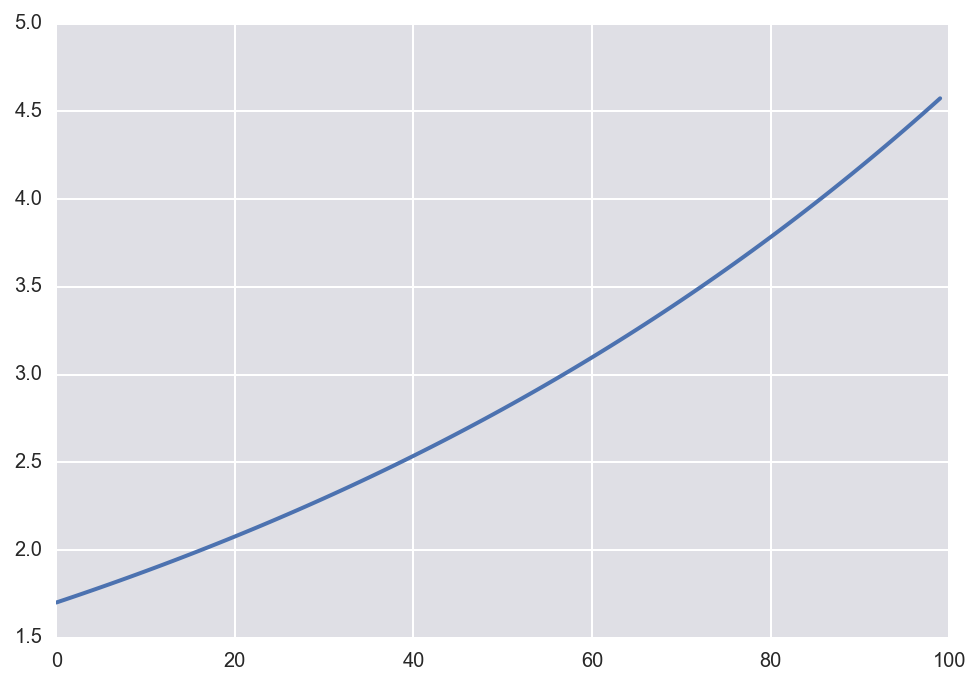

In [398]:
plt.plot(np.arange(100), exp_theor(np.array([1.7, 0.01]), np.arange(100)))

In [426]:
def sample_ptmcmc(times, areas, model, n_temps=20, n_walkers=100, n_burn=100, 
                  n_steps=500, threads=None):
    """
    Sample posterior using PTMCMC.
    """
    # arguments for likelihood
    loglargs = (times, areas, model)
    
    # arguments for prior
    logpargs = (model,)
    
    # starting points for the parameters
    p0 = params_start(n_walkers, n_temps, model)
    
    # column headings for outputted DataFrames
    columns = {'lin_theor': ['a_0', 'b'],
               'exp_theor': ['a_0', 'k']}
    
    return bebi103.run_pt_emcee(
            log_like, log_prior, n_burn, n_steps,
            n_temps=n_temps, p0=p0, loglargs=loglargs, logpargs=logpargs,
            threads=threads, columns=columns[model], return_lnZ=True)

In [427]:
start = time.time()
df_1, lnZ_1, dlnZ_1 = sample_ptmcmc(np.arange(len(area_series[0])), area_series[0], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=100, n_steps=500, threads=3)
print('PTMCMC took ', time.time()-start, ' seconds.')

PTMCMC took  18.028735160827637  seconds.


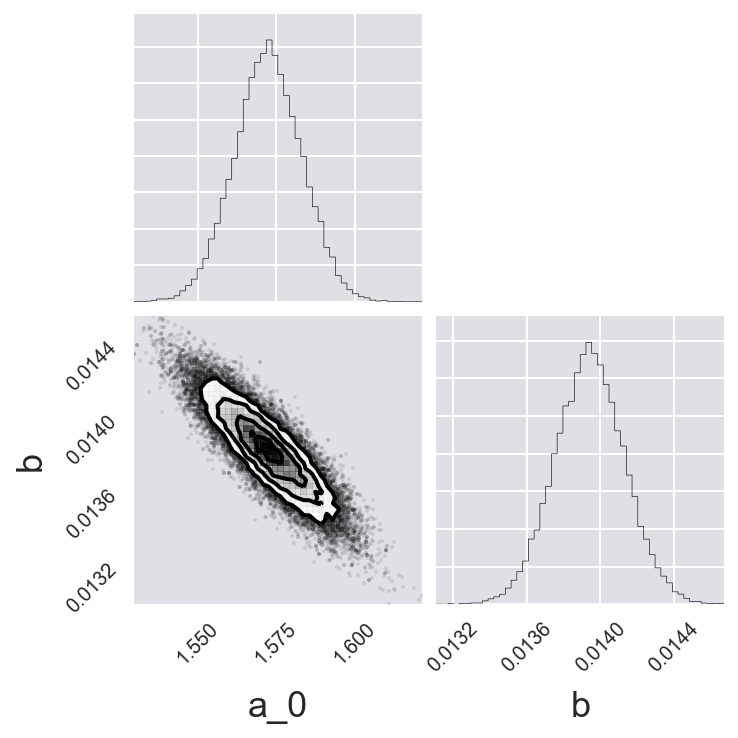

In [430]:
_ = corner.corner(df_1[df_1.beta_ind==0][['a_0', 'b']], bins=50)

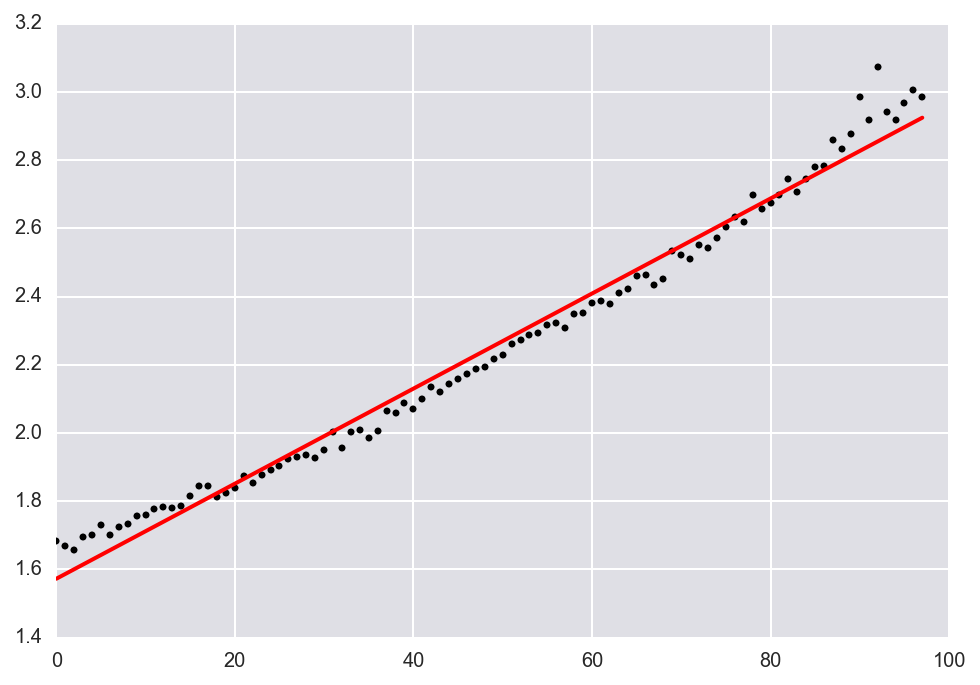

In [435]:
# Get the index of the most probable parameter set
df_map = df_1[(df_1.beta_ind==0) & (df_1.lnlike != -np.inf)]
max_ind = np.argmax(df_map.lnprob.values)

# Pull out values.
a_0_MAP, b_MAP = df_map.values[max_ind, :2]

# Print the results
# print("""Most probable parameter values:
# a_0:  {0:.3f}
# b: {1:.3f}
# """.format(a_0_MAP, b_MAP))

plt.plot(np.arange(len(area_series[0])), area_series[0], '.', color='k')
plt.plot(np.arange(len(area_series[0])),
         lin_theor(np.array([a_0_MAP, b_MAP]), np.arange(len(area_series[0]))), color='r')

In [436]:
start = time.time()
df_2, lnZ_2, dlnZ_2 = sample_ptmcmc(np.arange(len(area_series[0])), area_series[0], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=100, n_steps=500, threads=3)
print('PTMCMC took ', time.time()-start, ' seconds.')

PTMCMC took  18.400752067565918  seconds.


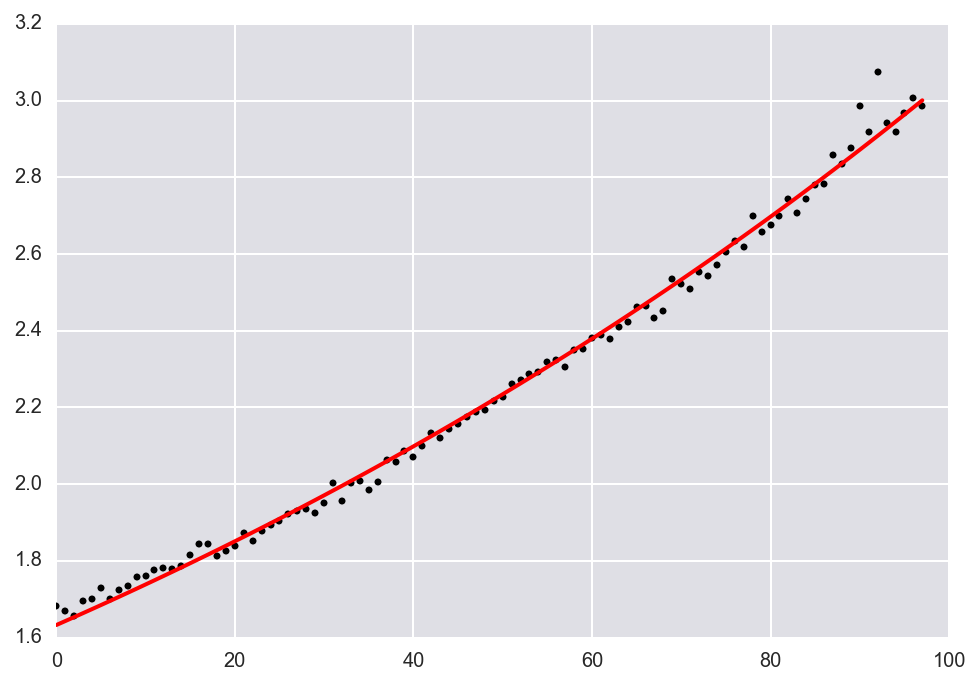

In [437]:
# Get the index of the most probable parameter set
df_map_exp = df_2[(df_2.beta_ind==0) & (df_2.lnlike != -np.inf)]
max_ind = np.argmax(df_map_exp.lnprob.values)

# Pull out values.
a_0_MAP_exp, k_MAP_exp = df_map_exp.values[max_ind, :2]

# Print the results
# print("""Most probable parameter values:
# a_0:  {0:.3f}
# b: {1:.3f}
# """.format(a_0_MAP, b_MAP))

plt.plot(np.arange(len(area_series[0])), area_series[0], '.', color='k')
plt.plot(np.arange(len(area_series[0])),
         exp_theor(np.array([a_0_MAP_exp, k_MAP_exp]), np.arange(len(area_series[0]))), color='r')

In [438]:
df1_no_inf = df_1[df_1['lnlike'] != -np.inf]
df2_no_inf = df_2[df_2['lnlike'] != -np.inf]

def lnZ(df_mcmc):
    """
    Compute log Z(1) from PTMCMC traces stored in DataFrame.
    """
    # Average the log likelihood over the samples
    log_mean = np.zeros(len(df_mcmc['beta_ind'].unique()))
    for i, b in enumerate(df_mcmc['beta_ind'].unique()):
        log_mean[i] = df_mcmc['lnlike'][df_mcmc['beta_ind']==b].mean()

    # Set of betas (temperatures)
    betas = np.concatenate((np.array(df_mcmc['beta'].unique()), (0,)))

    # Approximate quadrature
    return -np.dot(log_mean, np.diff(betas))

lnz1 = lnZ(df1_no_inf)
lnz2 = lnZ(df2_no_inf)

In [439]:
print('Odds ratio for linear vs exponential:', np.exp(lnz1 - lnz2))

Odds ratio for linear vs exponential: 6.50043522074e-24
